# CS585 Problem Set 2 (Total points: 40)

Assignment adapted from Margrit Betke and Saraubh Gupta

### Instructions

1.  Assignment is due at **5 PM on Tuesday Feb 15 2022**.

2.  Submission instructions:

    1.  A single `.pdf` report that contains your work for Q1, Q2 and
        Q3. For Q1 and Q2 you can either type out your responses in LaTeX, or
        any other word processing software.  You can also hand write them on a
        tablet, or scan in hand-written answers. If you hand-write, please make
        sure they are neat and legible. If you are scanning, make sure that the
        scans are legible. Lastly, convert your work into a `PDF`. 

        For Q3 your response should be electronic (no handwritten responses
        allowed). You should respond to the questions 3.1, 3.2 and 3.3
        individually and include images as necessary. Your response to Q3 in
        the PDF report should be self-contained. It should include all the
        output you want us to look at. You will not receive credit for any
        results you have obtained, but failed to include directly in the PDF
        report file. 

        PDF file should be submitted to
        [Gradescope](https://www.gradescope.com) under `PS2`. Please tag the reponses in your PDF with the Gradescope
        questions outline  as described in
        [Submitting an Assignment](https://youtu.be/u-pK4GzpId0). 

    2.  You also need to submit code for Q3 in the form of a single
        `.zip` file that includes all your code, all in the same
        directory. You can submit Python code in
        `.ipynb` format. Code should also be submitted to
        [Gradescope](https://www.gradescope.com) under `PS2-Code`. 
        *Not submitting your code will lead to a loss of
        100% of the points on Q3.*

    3.  We reserve the right to take off points for not following
        submission instructions. In particular, please tag the reponses
        in your PDF with the Gradescope questions outline as described
        in [Submitting an Assignment](https://youtu.be/u-pK4GzpId0). 



### Problems


1.  **Hausdorff Distance [10 pts total, 2 parts].**

  There are two shapes in the figure below. The triangle in red has three vertices: A(-2,3), B(3,1), and C(0,-3). The rectangle in blue has four vertices: D(-3,2), E(2,2), F(2,-1), and G(-3, -1).

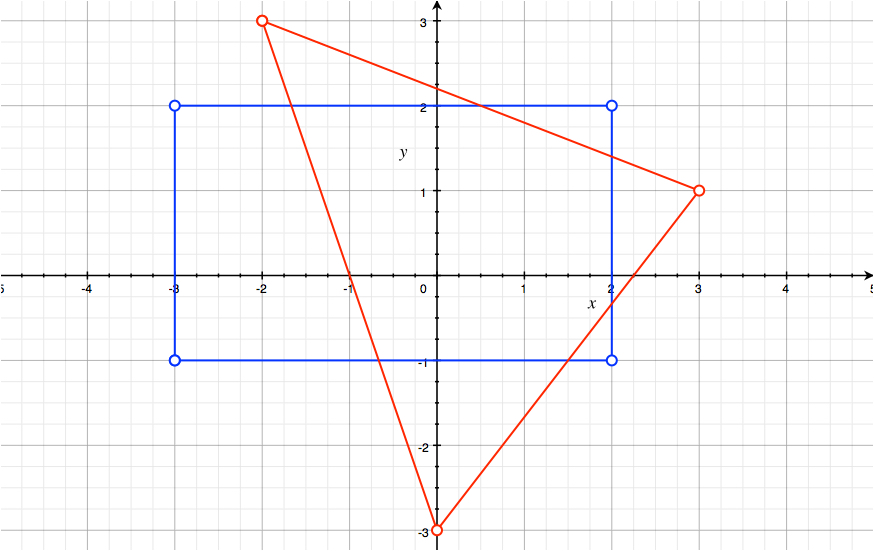

In [95]:
from PIL import Image
from IPython.display import display
display(Image.open('hausdorff.jpg'))

  1. **Distance between point sets [3 pts]** Consider two point sets S1 and S2, where S1={A, B, C} and S2={D, E, F, G}. Calculate the Hausdorff distance between these two point sets.

  2. **Distance between shapes [7 pts]** Now consider all the points forming these two polygons. What's the Hausdorff distance between the triangle and the rectangle?

2.  **Segmentation [10 pts].** The following tables include all the local maxima and local minima of the grayscale histogram of an image.

| Table 1: Local Maxima | |  |  |  |
| :---: | :---: | :---: | :---: | :---: | 
| Gray Values | 52 | 54 | 103 | 231 |
| # of Pixels | 1000 | 1170 | 1750 | 1300 |

| Table 2: Local Minima | |  |  |  | |
| :---: | :---: | :---: | :---: | :---: | :---: |
| Gray Values | 0 | 53 | 75 | 157 | 255 |
| # of Pixels | 500 | 590 | 240 | 190 | 310 |

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Calculate the highest peakiness and the corresponding threshold using Mode Method.

3.  **Contour Detection [20 pts]**. In this problem we will build a basic contour detector. 

  We have implemented a contour detector that uses the magnitude of the local image gradient as the boundary score as seen below:

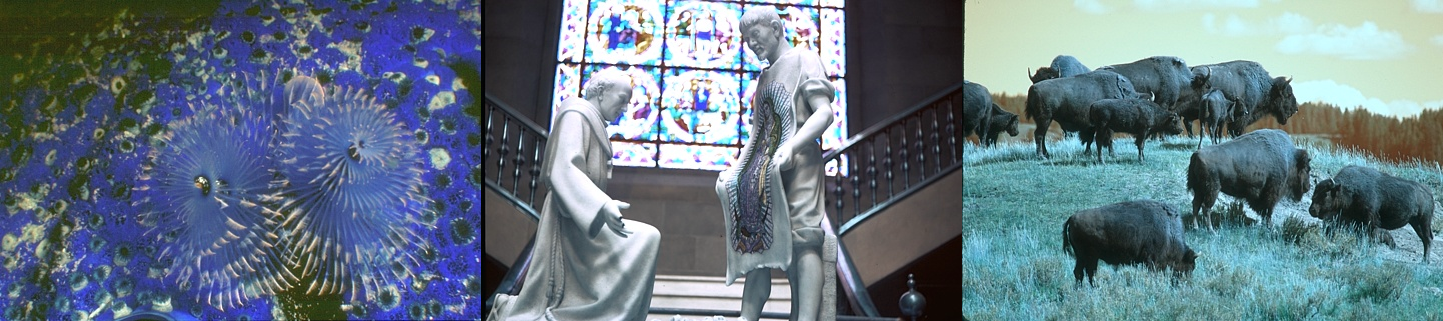

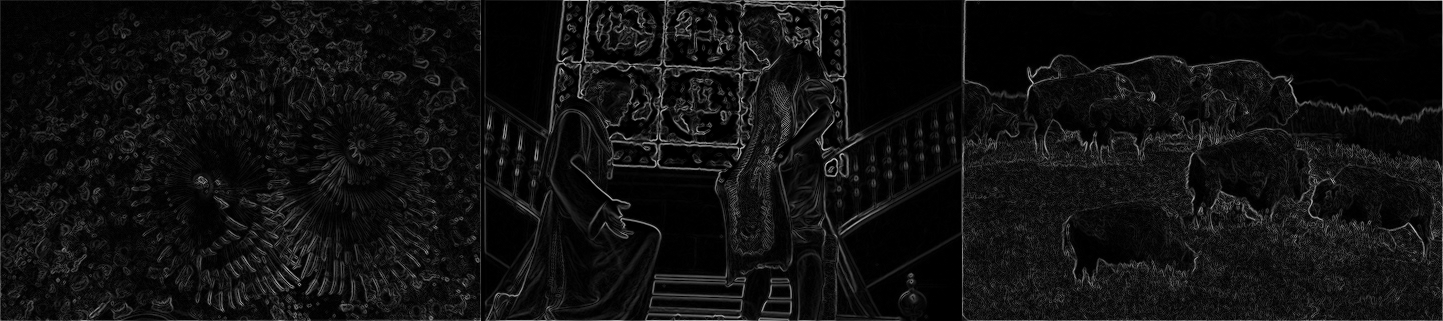

Overall F1 score: 0.4163603293750655


In [1]:
from PIL import Image
import numpy as np
import cv2, os
from scipy.io import loadmat
from scipy import signal
import evaluate_boundaries
from scipy import ndimage

N_THRESHOLDS = 99

def detect_edges(imlist, fn):
  images, edges = [], []
  for imname in imlist:
    I = cv2.imread(os.path.join('data', str(imname)+'.jpg'))
    images.append(I)

    I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    I = I.astype(np.float32)/255.
    mag = fn(I)
    edges.append(mag)
  return images, edges

def evaluate(imlist, all_predictions):
  count_r_overall = np.zeros((N_THRESHOLDS,))
  sum_r_overall = np.zeros((N_THRESHOLDS,))
  count_p_overall = np.zeros((N_THRESHOLDS,))
  sum_p_overall = np.zeros((N_THRESHOLDS,))
  for imname, predictions in zip(imlist, all_predictions):
    gt = loadmat(os.path.join('data', str(imname)+'.mat'))['groundTruth']
    num_gts = gt.shape[1]
    gt = [gt[0,i]['Boundaries'][0,0] for i in range(num_gts)]
    count_r, sum_r, count_p, sum_p, used_thresholds = \
              evaluate_boundaries.evaluate_boundaries_fast(predictions, gt, 
                                                           thresholds=N_THRESHOLDS,
                                                           apply_thinning=True)
    count_r_overall += count_r
    sum_r_overall += sum_r
    count_p_overall += count_p
    sum_p_overall += sum_p

  rec_overall, prec_overall, f1_overall = evaluate_boundaries.compute_rec_prec_f1(
        count_r_overall, sum_r_overall, count_p_overall, sum_p_overall)
  
  return max(f1_overall)

def compute_edges_dxdy(I):
  """Returns the norm of dx and dy as the edge response function."""
  
  dx = signal.convolve2d(I, np.array([[-1, 0, 1]]), mode='same')
  dy = signal.convolve2d(I, np.array([[-1, 0, 1]]).T, mode='same')
  mag = np.sqrt(dx**2 + dy**2)
  mag = normalize(mag)
  return mag

def normalize(mag):
  mag = mag / 1.5
  mag = mag * 255.
  mag = np.clip(mag, 0, 255)
  mag = mag.astype(np.uint8)
  return mag


imlist = [12084, 24077, 38092]
fn = compute_edges_dxdy
images, edges = detect_edges(imlist, fn)
display(Image.fromarray(np.hstack(images)))
display(Image.fromarray(np.hstack(edges)))
f1 = evaluate(imlist, edges)
print('Overall F1 score:', f1)

  1.  **[2 pts] Warm-up.** As you visualize the produced edges, you will notice artifacts at image boundaries. Modify how the convolution is being done to minimize these artifacts.

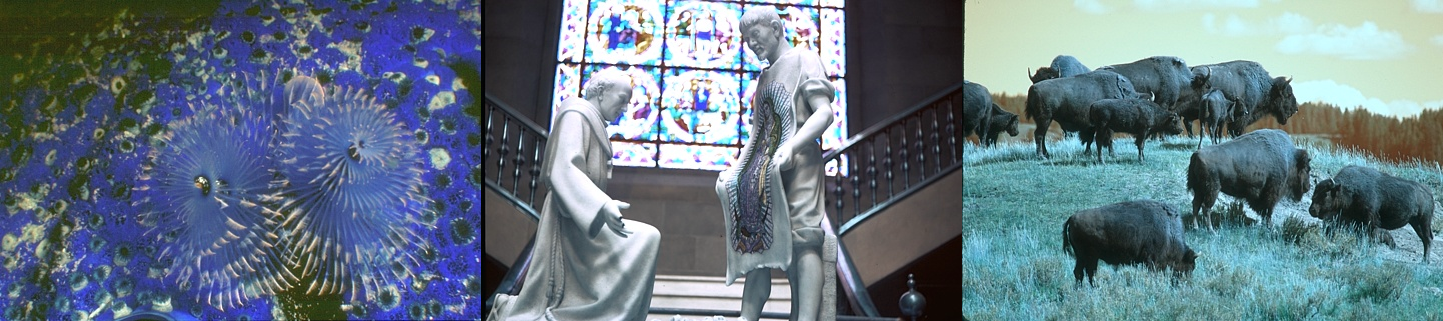

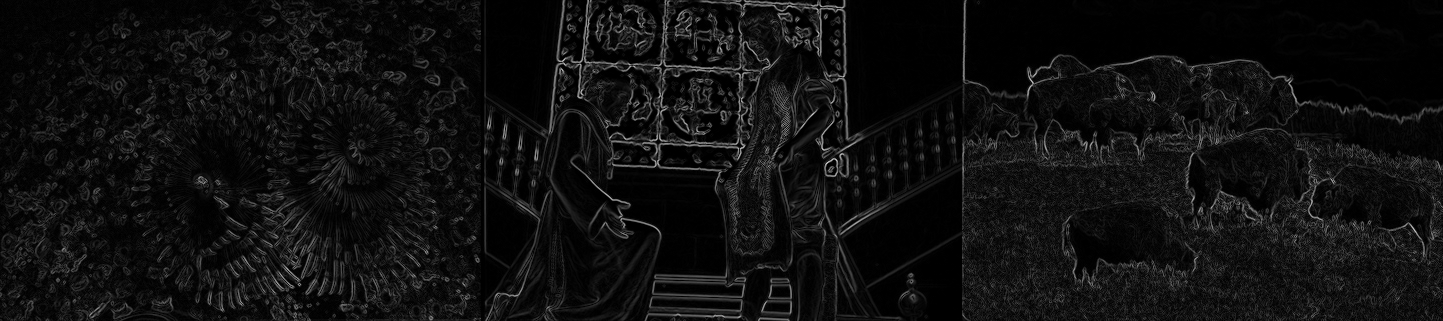

Overall F1 score: 0.4175307435125027


In [2]:
def compute_edges_dxdy_warmup(I):
  """Hint: Look at arguments for scipy.signal.convolve2d"""
  # ADD CODE HERE

  dx = signal.convolve2d(I, np.array([[-1, 0, 1]]), mode='same', boundary="symm")
  dy = signal.convolve2d(I, np.array([[-1, 0, 1]]).T, mode='same', boundary="symm")
  mag = np.sqrt(dx**2 + dy**2)
  mag = normalize(mag)
  return mag


imlist = [12084, 24077, 38092]
fn = compute_edges_dxdy_warmup
images, edges = detect_edges(imlist, fn)
display(Image.fromarray(np.hstack(images)))
display(Image.fromarray(np.hstack(edges)))
f1 = evaluate(imlist, edges)
print('Overall F1 score:', f1)

  2.  **[5 pts] Smoothing.** Next, notice that we are using [−1, 0, 1] filters for computing the gradients, and they are susceptible to noise. Use derivative of Gaussian filters to obtain more robust estimates of the gradient. Experiment with different sigma for this Gaussian filtering and pick the one that works the best.

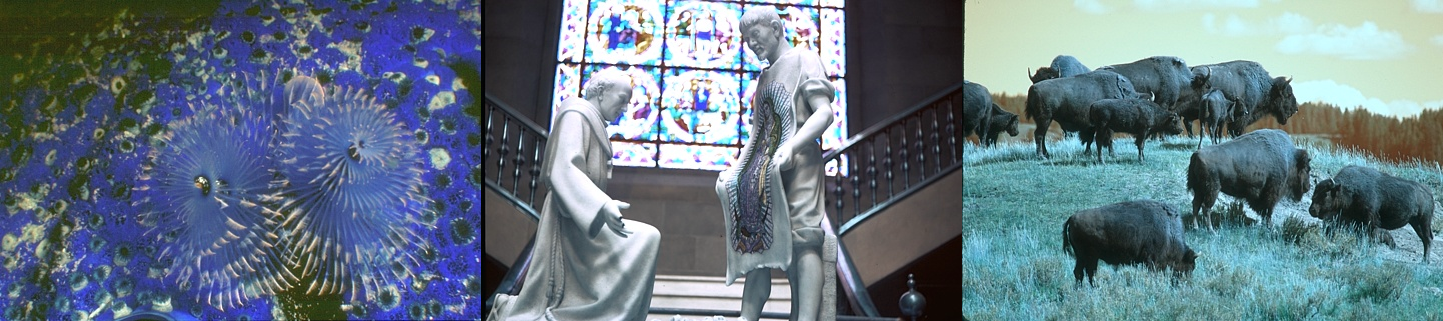

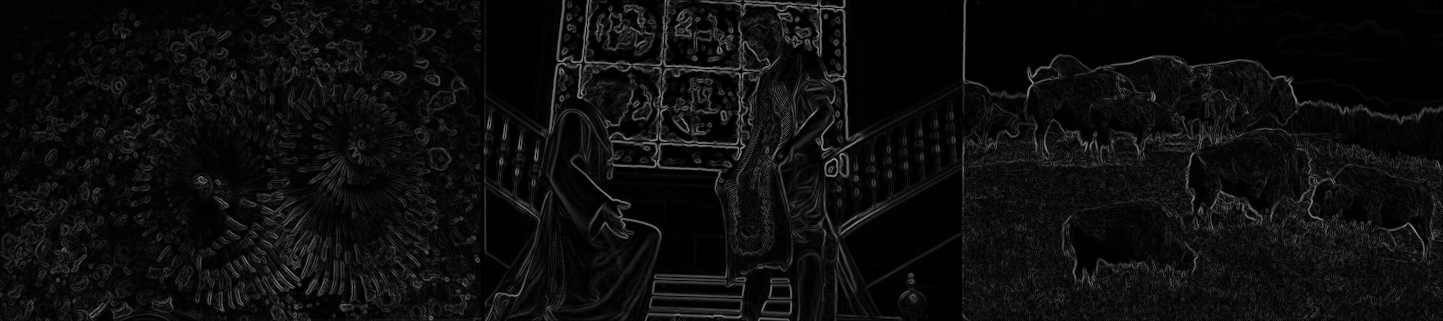

Overall F1 score: 0.4195793230186947


In [3]:
def compute_edges_dxdy_smoothing(I):
  """ Copy over your response from part 3.1 and alter it
  to include this answer. See cv2.GaussianBlur"""
  # ADD CODE HERE

  I = cv2.GaussianBlur(I, (3,3), 0.51)
    
  dx = signal.convolve2d(I, np.array([[-1, 0, 1]]), mode='same', boundary="symm")
  dy = signal.convolve2d(I, np.array([[-1, 0, 1]]).T, mode='same', boundary="symm")
  mag = np.sqrt(dx**2 + dy**2)
  mag = normalize(mag)
  return mag


imlist = [12084, 24077, 38092]
fn = compute_edges_dxdy_smoothing
images, edges = detect_edges(imlist, fn)
display(Image.fromarray(np.hstack(images)))
display(Image.fromarray(np.hstack(edges)))
f1 = evaluate(imlist, edges)
print('Overall F1 score:', f1)

  3.  **[8 pts] Non-maximum Suppression.** The current code does not produce thin edges. Implement non-maximum suppression, where we look at the gradient magnitude at the two neighbours in the direction perpendicular to the edge. We suppress the output at the current pixel if the output at the current pixel is not more than at the neighbors. You will have to compute the orientation of the contour (using the X and Y gradients), and then lookup values at the neighbouring pixels.

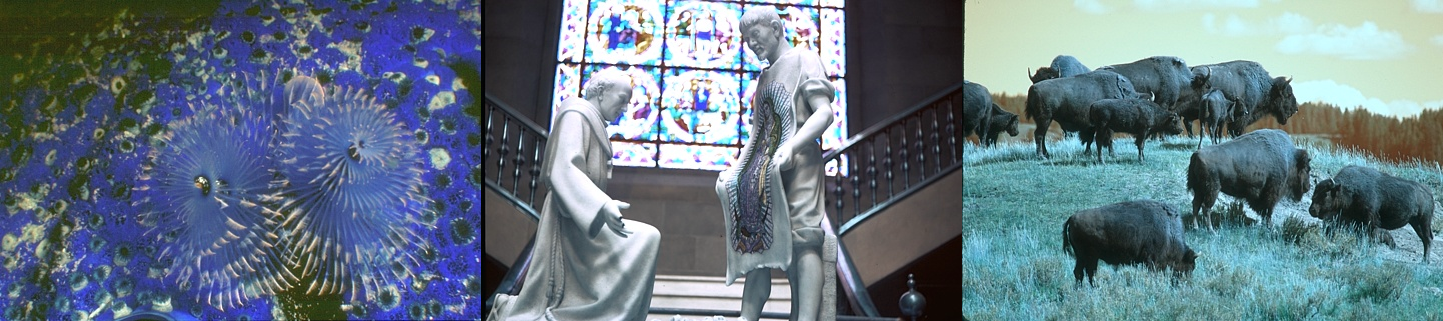

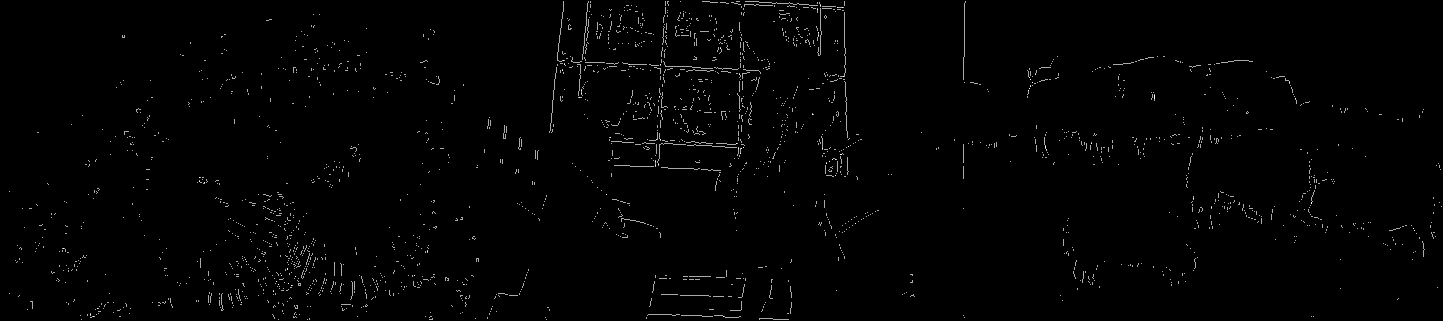

Overall F1 score: 0.5976593536089015


In [4]:
def compute_edges_dxdy_nonmax(I):
  """ Copy over your response from part 3.2 and alter it
  to include this response"""
  # ADD CODE  HERE

  I = cv2.GaussianBlur(I, (3,3), 0.5)
    
  dx = signal.convolve2d(I, np.array([[-1, 0, 1]]), mode='same', boundary="symm")
  dy = signal.convolve2d(I, np.array([[-1, 0, 1]]).T, mode='same', boundary="symm")

  Grad = np.hypot(dx, dy)
  Grad = Grad / Grad.max() * 2.4
  theta = np.arctan2(dy, dx)

  mag = NMS(Grad, theta)
  mag = normalize(mag)
  
  return mag

def NMS(grad, theta):
    X, Y = grad.shape
    output = np.zeros((X,Y), dtype=np.int32)
    theta = theta * 180. / np.pi
    theta[theta < 0] += 180
    for i in range(1,X-1):
        for j in range(1,Y-1):
            try:
                m = n = 255
                if (0 <= theta[i,j] < 22.5):
                    m = grad[i, j+1]
                    n = grad[i, j-1]
                elif (157.5 <= theta[i,j] <= 180):
                    m = grad[i, j+1]
                    n = grad[i, j-1]
                elif (22.5 <= theta[i,j] < 67.5):
                    m = grad[i+1, j-1]
                    n = grad[i-1, j+1]
                elif (67.5 <= theta[i,j] < 112.5):
                    m = grad[i+1, j]
                    n = grad[i-1, j]
                elif (112.5 <= theta[i,j] < 157.5):
                    m = grad[i-1, j-1]
                    n = grad[i+1, j+1]
                if (grad[i,j] >= m) and (grad[i,j] >= n):
                    output[i,j] = grad[i,j]
                else:
                    output[i,j] = 0

            except IndexError as e:
                    pass
    return output

imlist = [12084, 24077, 38092]
fn = compute_edges_dxdy_nonmax
images, edges = detect_edges(imlist, fn)
display(Image.fromarray(np.hstack(images)))
display(Image.fromarray(np.hstack(edges)))
f1 = evaluate(imlist, edges)
print('Overall F1 score:', f1)